In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Data

In [76]:
df = sns.load_dataset('flights')
df

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121
...,...,...,...
139,1960,Aug,606
140,1960,Sep,508
141,1960,Oct,461
142,1960,Nov,390


In [77]:
df['month'] = pd.factorize(df['month'])[0]+1
df['year'] = df['year'].astype(str)
df['month'] = df['month'].astype(str)
df['date'] = df['year']+'-'+df['month']
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df

,year,month,passengers
date,,,
1949-01-01,1949,1,112
1949-02-01,1949,2,118
1949-03-01,1949,3,132
1949-04-01,1949,4,129
1949-05-01,1949,5,121
...,...,...,...
1960-08-01,1960,8,606
1960-09-01,1960,9,508
1960-10-01,1960,10,461


## train test split

In [78]:
# 1960년 일별 예측하고 싶음

# 이렇게 되면 lag feature로 인해 df_valid, df_test 가 5개 밖에 안남음
# 데이터수가 적으므로 불가능
years = df.index.year
# df_Train = df.loc[years<=1959]
# df_test = df.loc[years==1960]

# df_train = df.loc[years<=1958]
# df_valid = df.loc[years==1959]

In [79]:
# df 먼저 supervise set 만들고 잘라야함

# Data analysis

## visualize

<AxesSubplot:xlabel='date'>

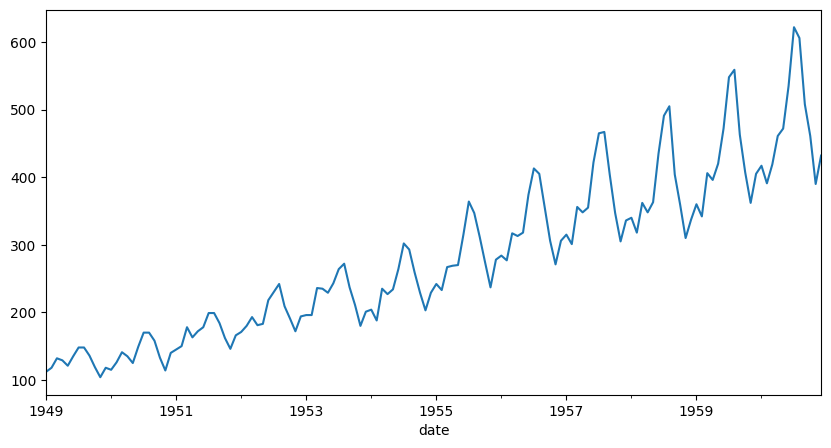

In [80]:
fig, ax = plt.subplots(figsize=(10,5))
df['passengers'].plot(ax=ax)

<AxesSubplot:xlabel='date'>

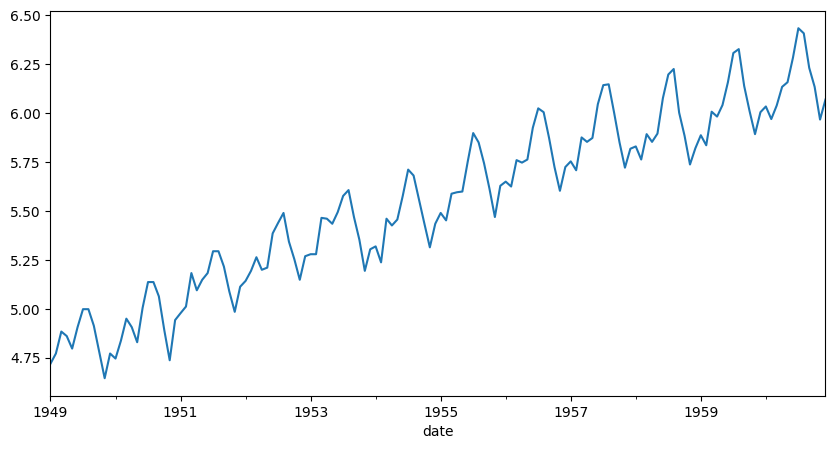

In [81]:
df['log_passengers'] = np.log(df['passengers'])
fig, ax = plt.subplots(figsize=(10,5))
df['log_passengers'].plot(ax=ax)

## stationary

In [82]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['log_passengers'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key,value in result[4].items():
    print('%s: %.3f' %(key,value))
    
# for key, value in result[4].items():
#      print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.717017
p-value: 0.422367
1%: -3.482
5%: -2.884
10%: -2.579


## seasonality

### fourier transformation

(-20.0, 20.0)

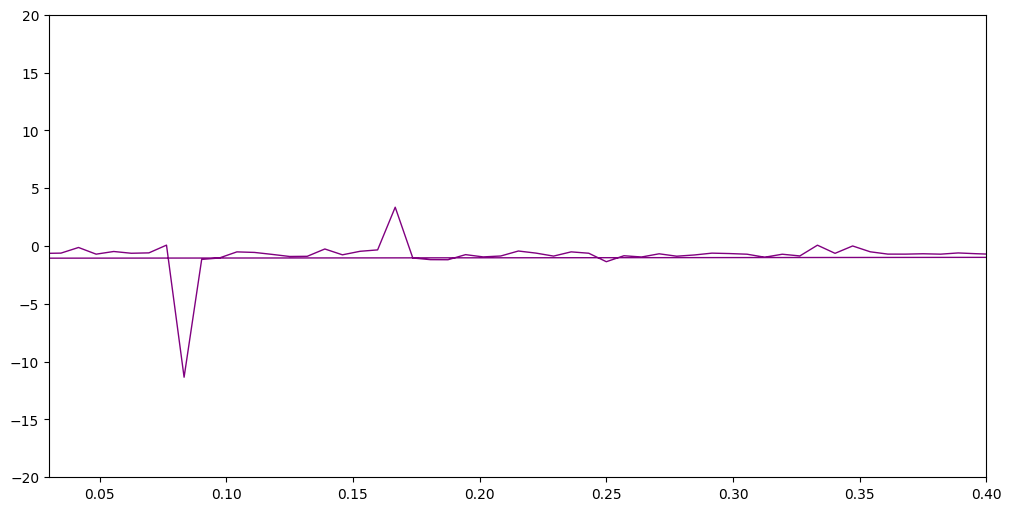

In [83]:
sp = np.fft.fft(df['log_passengers'])
freq = np.fft.fftfreq(df['log_passengers'].shape[0])

fig,ax = plt.subplots(figsize=(10,5), constrained_layout=True)
ax.plot(freq, sp.real, lw=1, c='purple')
ax.set_xlim(0.03,0.4)
ax.set_ylim(-20,20)

Text(0.08333333333333333, -10, '$12^{-1}$')

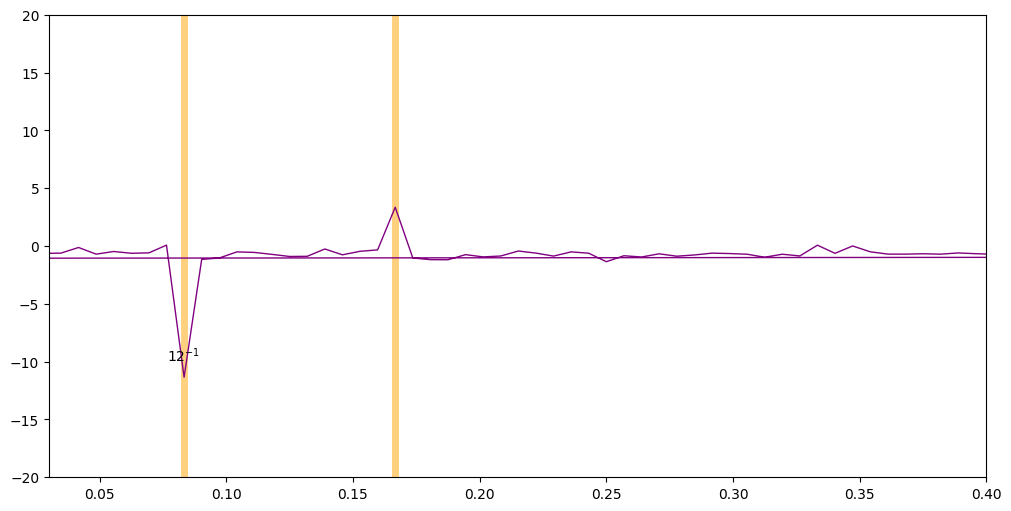

In [84]:
fig,ax = plt.subplots(figsize=(10,5), constrained_layout=True)
ax.plot(freq, sp.real, lw=1, c='purple')
ax.set_xlim(0.03,0.4)
ax.set_ylim(-20,20)

# 월단위 데이터
ax.axvline(1/12, c="orange", lw=5, alpha=0.5, zorder=0)
ax.axvline(2/12, c="orange", lw=5, alpha=0.5, zorder=0)

# text
ax.text(1/12, -10, r"$12^{-1}$", ha="center")

### autocorrealtion

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

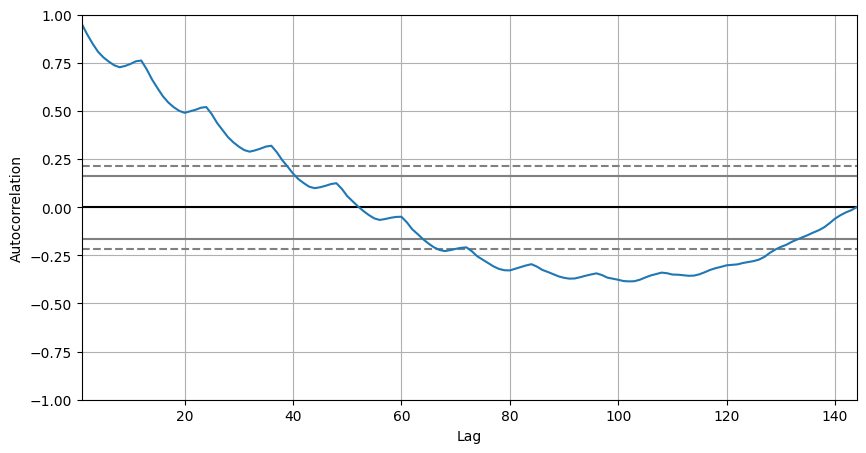

In [85]:
# (1) pd.plotting.autocorrelation

fig,ax = plt.subplots(figsize=(10,5))
pd.plotting.autocorrelation_plot(df['log_passengers'])

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

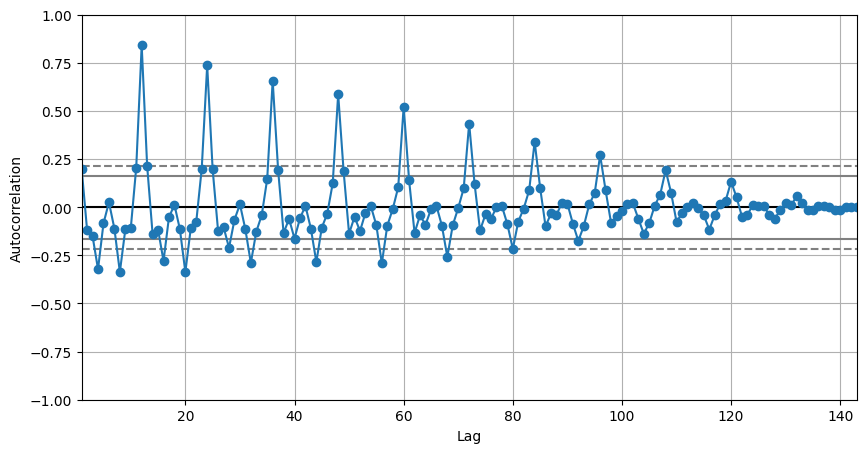

In [86]:
fig,ax = plt.subplots(figsize=(10,5))
pd.plotting.autocorrelation_plot(df['log_passengers'].diff().dropna(),marker='o')

(-1.0, 60.0)

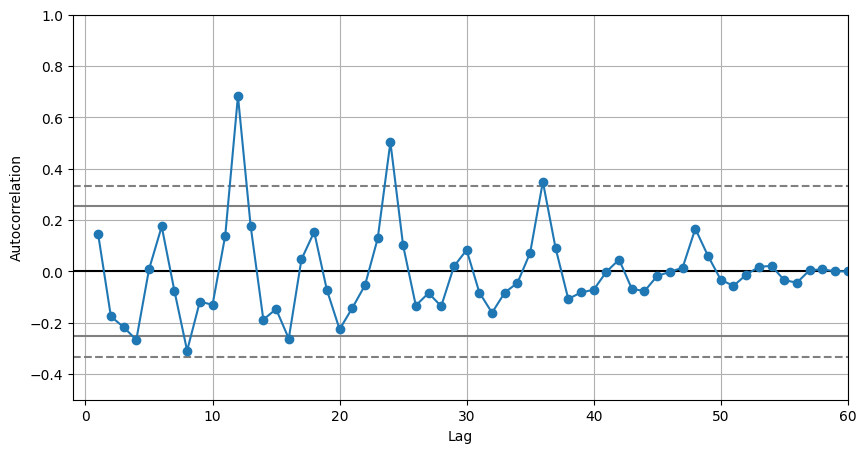

In [87]:
# 데이터 수가 적으면 잘 안보임
fig,ax = plt.subplots(figsize=(10,5))
detrend_1 = df['log_passengers'].diff().dropna()
pd.plotting.autocorrelation_plot(detrend_1.iloc[:60],marker='o')
ax.set_ylim(-0.5,1)
ax.set_xlim(-1,)

## feature extraction

In [88]:
df.index.max()

Timestamp('1960-12-01 00:00:00')

<AxesSubplot:xlabel='month', ylabel='log_passengers'>

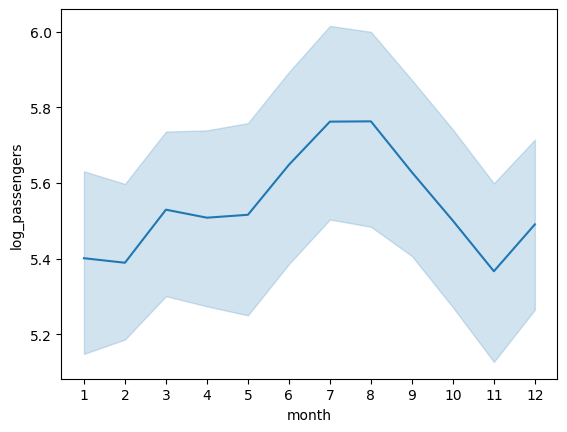

In [89]:
sns.lineplot(x='month', y='log_passengers', data=df)

<AxesSubplot:xlabel='month', ylabel='log_passengers'>

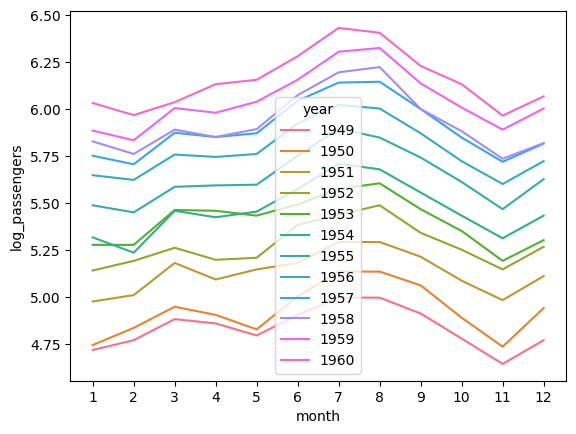

In [90]:
sns.lineplot(x='month', y='log_passengers', data=df, hue='year')

## time series decomposition

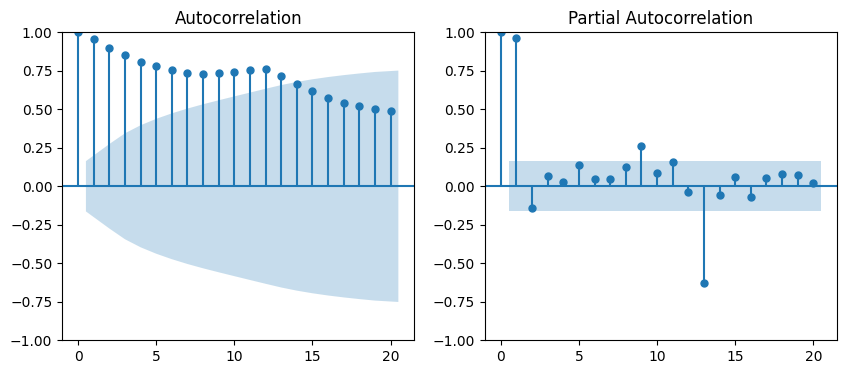

In [91]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
fig,axs = plt.subplots(ncols=2,figsize=(10,4))
acf = plot_acf(df['log_passengers'],lags=20, ax=axs[0])
pacf = plot_pacf(df['log_passengers'],lags=20, ax=axs[1])

In [92]:
from statsmodels.tsa.seasonal import STL
stl = STL(df['log_passengers'],seasonal=13)
res = stl.fit()
detrend = res.seasonal + res.resid

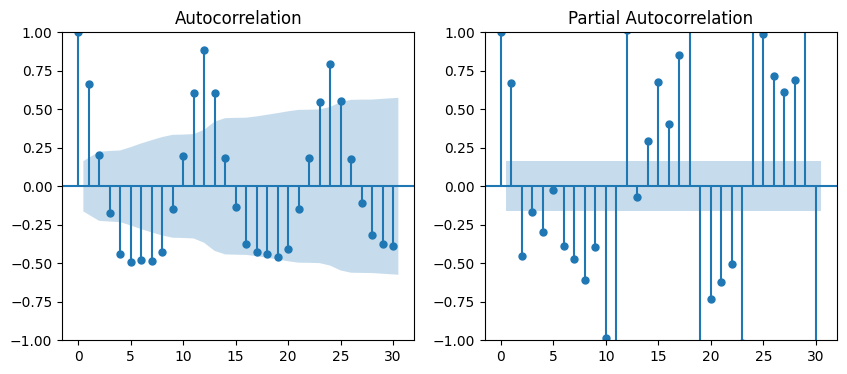

In [93]:
fig,axs = plt.subplots(ncols=2,figsize=(10,4))
acf = plot_acf(detrend,lags=30, ax=axs[0])
pacf = plot_pacf(detrend,lags=30, ax=axs[1])

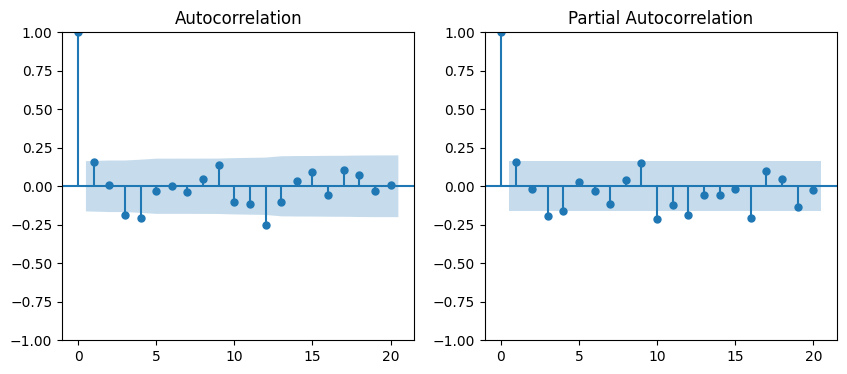

In [94]:
fig,axs = plt.subplots(ncols=2,figsize=(10,4))
acf = plot_acf(res.resid,lags=20, ax=axs[0])
pacf = plot_pacf(res.resid,lags=20, ax=axs[1])

# Predict1: only lag feature

## max_lags = 10

In [95]:
max_lags= 10
col = 'log_passengers'
df_1 = df.copy()
for i in range(1,max_lags+1):
    df_1[f"lag_{i}"] = df_1[col].shift(i)

In [96]:
df_1 = df_1.iloc[10:]
df_1

,year,month,passengers,log_passengers,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
date,,,,,,,,,,,,,,
1949-11-01,1949,11,104,4.644391,4.779123,4.912655,4.997212,4.997212,4.905275,4.795791,4.859812,4.882802,4.770685,4.718499
1949-12-01,1949,12,118,4.770685,4.644391,4.779123,4.912655,4.997212,4.997212,4.905275,4.795791,4.859812,4.882802,4.770685
1950-01-01,1950,1,115,4.744932,4.770685,4.644391,4.779123,4.912655,4.997212,4.997212,4.905275,4.795791,4.859812,4.882802
1950-02-01,1950,2,126,4.836282,4.744932,4.770685,4.644391,4.779123,4.912655,4.997212,4.997212,4.905275,4.795791,4.859812
1950-03-01,1950,3,141,4.948760,4.836282,4.744932,4.770685,4.644391,4.779123,4.912655,4.997212,4.997212,4.905275,4.795791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1960-08-01,1960,8,606,6.406880,6.432940,6.282267,6.156979,6.133398,6.037871,5.968708,6.033086,6.003887,5.891644,6.008813
1960-09-01,1960,9,508,6.230481,6.406880,6.432940,6.282267,6.156979,6.133398,6.037871,5.968708,6.033086,6.003887,5.891644
1960-10-01,1960,10,461,6.133398,6.230481,6.406880,6.432940,6.282267,6.156979,6.133398,6.037871,5.968708,6.033086,6.003887


## train test split

In [98]:
years = df_1.index.year

df_train = df_1.loc[years<=1958]
df_valid = df_1.loc[years==1959]

df_Train = df_1.loc[years<=1959]
df_test = df_1.loc[years==1960]

In [99]:
X_features = [f"lag_{i}" for i in range(1,max_lags+1)]
X_features

X_train = df_train[X_features]
y_train = df_train[col]

X_valid = df_valid[X_features]
y_valid = df_valid[col]

X_Train = df_Train[X_features]
y_Train = df_Train[col]

X_test = df_test[X_features]
y_test = df_test[col]

In [102]:
X_test

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
date,,,,,,,,,,
1960-01-01,6.003887,5.891644,6.008813,6.137727,6.326149,6.306275,6.156979,6.040255,5.981414,6.006353
1960-02-01,6.033086,6.003887,5.891644,6.008813,6.137727,6.326149,6.306275,6.156979,6.040255,5.981414
1960-03-01,5.968708,6.033086,6.003887,5.891644,6.008813,6.137727,6.326149,6.306275,6.156979,6.040255
1960-04-01,6.037871,5.968708,6.033086,6.003887,5.891644,6.008813,6.137727,6.326149,6.306275,6.156979
1960-05-01,6.133398,6.037871,5.968708,6.033086,6.003887,5.891644,6.008813,6.137727,6.326149,6.306275
1960-06-01,6.156979,6.133398,6.037871,5.968708,6.033086,6.003887,5.891644,6.008813,6.137727,6.326149
1960-07-01,6.282267,6.156979,6.133398,6.037871,5.968708,6.033086,6.003887,5.891644,6.008813,6.137727
1960-08-01,6.432940,6.282267,6.156979,6.133398,6.037871,5.968708,6.033086,6.003887,5.891644,6.008813
1960-09-01,6.406880,6.432940,6.282267,6.156979,6.133398,6.037871,5.968708,6.033086,6.003887,5.891644


In [103]:
y_test

date
1960-01-01    6.033086
1960-02-01    5.968708
1960-03-01    6.037871
1960-04-01    6.133398
1960-05-01    6.156979
1960-06-01    6.282267
1960-07-01    6.432940
1960-08-01    6.406880
1960-09-01    6.230481
1960-10-01    6.133398
1960-11-01    5.966147
1960-12-01    6.068426
Name: log_passengers, dtype: float64

## model == LinearRegression

In [100]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train,y_train)
y_pred_train = model.predict(X_train)
y_pred_valid = model.predict(X_valid)

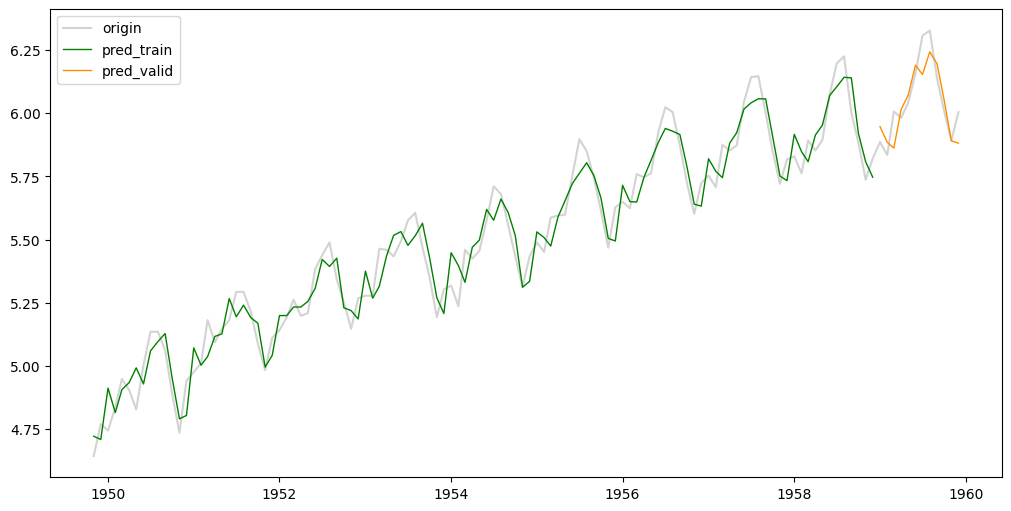

In [108]:
fig,ax = plt.subplots(figsize=(10,5),constrained_layout=True)
ax.plot(X_Train.index, y_Train, c="lightgray", label='origin')
ax.plot(df_train.index, y_pred_train, c='g',lw=1, label='pred_train')
ax.plot(df_valid.index, y_pred_valid, c='darkorange', lw=1, label='pred_valid')
ax.legend()

## result

In [116]:
from sklearn.metrics import r2_score, mean_absolute_error

def plot_parity(y_true,y_pred,c,ax):
    ax.scatter(y_true, y_pred, c=c, alpha=0.5)
    ax.axline((y_true.mean(), y_true.mean()), slope=1, c='k')
    
    ax.text(0.95, 0.2, f"R2={r2_score(y_true,y_pred)}",ha="right",transform=ax.transAxes )
    ax.text(0.95, 0.1, f"MAE ={mean_absolute_error(y_true,y_pred)}", ha="right",transform=ax.transAxes)

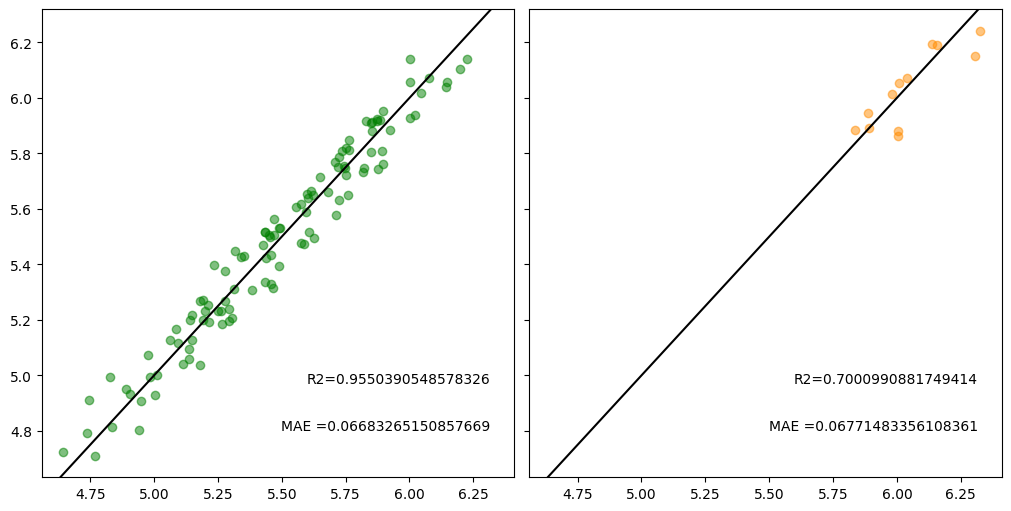

In [117]:
fig, axs = plt.subplots(ncols=2, figsize=(10,5), constrained_layout=True, sharex=True, sharey=True)
plot_parity(y_train, y_pred_train,c='g',ax=axs[0])
plot_parity(y_valid, y_pred_valid, c='darkorange', ax=axs[1])

## model == Randomforest
extrapolate 문제있음

In [118]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
model.fit(X_train,y_train)
y_pred_train = model.predict(X_train)
y_pred_valid = model.predict(X_valid)

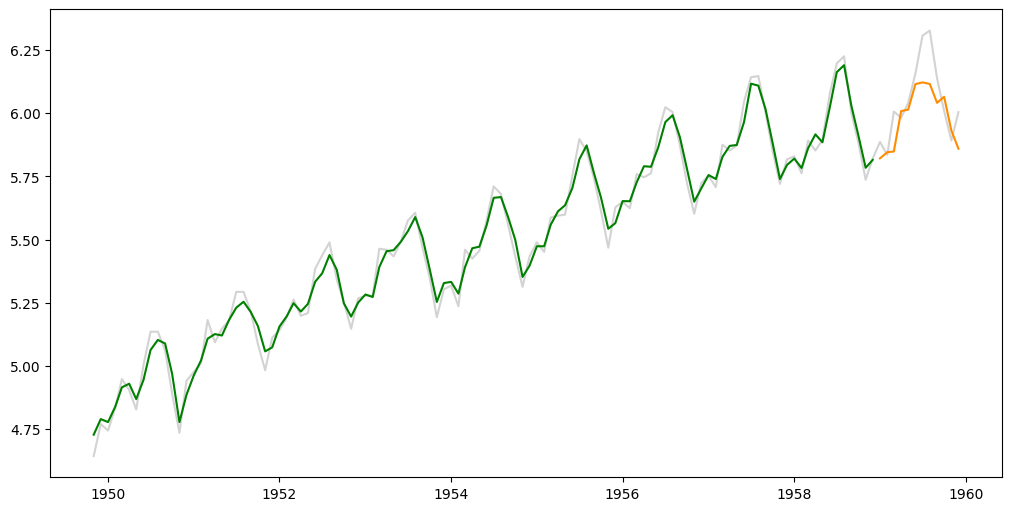

In [121]:
fig,ax = plt.subplots(figsize=(10,5), constrained_layout=True)
ax.plot(X_Train.index, y_Train, c='lightgray')
ax.plot(X_train.index, y_pred_train, c='g')
ax.plot(X_valid.index, y_pred_valid, c='darkorange')

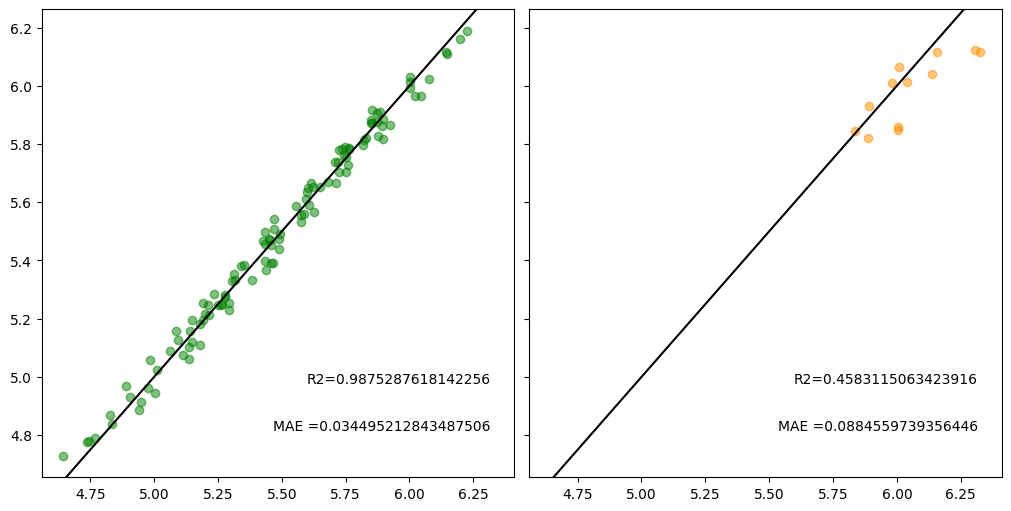

In [122]:
 fig, axs = plt.subplots(ncols=2, figsize=(10,5), constrained_layout=True, sharex=True, sharey=True)
plot_parity(y_train, y_pred_train,c='g',ax=axs[0])
plot_parity(y_valid, y_pred_valid, c='darkorange', ax=axs[1])

# Predict2: use all feature( + pipeline)

In [133]:
df_2 = df.copy()
df_2.head()

,year,month,passengers,log_passengers
date,,,,
1949-01-01,1949,1,112,4.718499
1949-02-01,1949,2,118,4.770685
1949-03-01,1949,3,132,4.882802
1949-04-01,1949,4,129,4.859812
1949-05-01,1949,5,121,4.795791


In [138]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            144 non-null    object 
 1   month           144 non-null    object 
 2   passengers      144 non-null    int64  
 3   log_passengers  144 non-null    float64
 4   delta           144 non-null    int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 6.8+ KB


In [136]:
# delta
# df_2['delta'] = (df_2.index - df_2.index[0]).month
df_2['delta'] = [i for i in range(len(df_2))]

In [139]:
# cyclical feature
df_2['month'] = df_2.index.month
df_2['month_sin'] = df_2['month'].apply(lambda x: np.sin(x/12*2*np.pi))
df_2['month_cos'] = df_2['month'].apply(lambda x: np.cos(x/12*2*np.pi))
df_2 = df_2.drop(columns=['month'])

In [140]:
 df_2.head()

,year,passengers,log_passengers,delta,month_sin,month_cos
date,,,,,,
1949-01-01,1949,112,4.718499,0,0.500000,8.660254e-01
1949-02-01,1949,118,4.770685,1,0.866025,5.000000e-01
1949-03-01,1949,132,4.882802,2,1.000000,6.123234e-17
1949-04-01,1949,129,4.859812,3,0.866025,-5.000000e-01
1949-05-01,1949,121,4.795791,4,0.500000,-8.660254e-01


In [141]:
max_lags = 10
col = 'log_passengers'
for i in range(1,max_lags+1):
    df_2[f'lag_{i}'] = df_2[col].shift(i)
df_2.head()

,year,passengers,log_passengers,delta,month_sin,month_cos,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
date,,,,,,,,,,,,,,,,
1949-01-01,1949,112,4.718499,0,0.500000,8.660254e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949-02-01,1949,118,4.770685,1,0.866025,5.000000e-01,4.718499,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949-03-01,1949,132,4.882802,2,1.000000,6.123234e-17,4.770685,4.718499,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949-04-01,1949,129,4.859812,3,0.866025,-5.000000e-01,4.882802,4.770685,4.718499,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949-05-01,1949,121,4.795791,4,0.500000,-8.660254e-01,4.859812,4.882802,4.770685,4.718499,NaN,NaN,NaN,NaN,NaN,NaN


In [143]:
X_features = df_2.columns.drop(['year','passengers','log_passengers'])
X_features

Index(['delta', 'month_sin', 'month_cos', 'lag_1', 'lag_2', 'lag_3', 'lag_4',
       'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10'],
      dtype='object')

## train test split

In [148]:
df_2 = df_2.iloc[max_lags:]
years = df_2.index.year

df_train = df_2.loc[years<=1958]
df_valid = df_2.loc[years==1959]

df_Train = df_2.loc[years<=1959]
df_test = df_2.loc[years==1960]

In [149]:
X_train = df_train[X_features]
y_train = df_train[col]

X_valid = df_valid[X_features]
y_valid = df_valid[col]

X_Train = df_Train[X_features]
y_Train = df_Train[col]

X_test = df_test[X_features]
y_test = df_test[col]

## model == LinearRegression

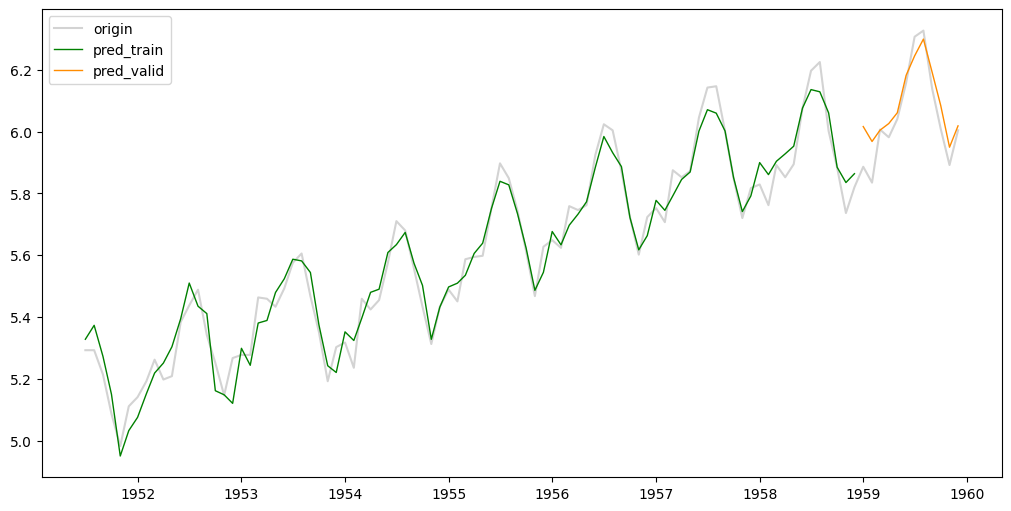

In [150]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train,y_train)
y_pred_train = model.predict(X_train)
y_pred_valid = model.predict(X_valid)

fig,ax = plt.subplots(figsize=(10,5),constrained_layout=True)
ax.plot(X_Train.index, y_Train, c="lightgray", label='origin')
ax.plot(df_train.index, y_pred_train, c='g',lw=1, label='pred_train')
ax.plot(df_valid.index, y_pred_valid, c='darkorange', lw=1, label='pred_valid')
ax.legend()

## pipeline

In [151]:
df_2 = df[['log_passengers']].copy()
df_2.head()

,log_passengers
date,
1949-01-01,4.718499
1949-02-01,4.770685
1949-03-01,4.882802
1949-04-01,4.859812
1949-05-01,4.795791


In [155]:
from sklearn.pipeline import Pipeline
from feature_engine.timeseries.forecasting import LagFeatures, WindowFeatures
from feature_engine.creation import CyclicalFeatures
from feature_engine.datetime import DatetimeFeatures
from feature_engine.imputation import DropMissingData
from feature_engine.selection import DropFeatures

In [163]:
# datetime feature

dtf = DatetimeFeatures(
        variables="index",
        features_to_extract=[
            "month"
        ])

In [170]:
# lag feature
lagf = LagFeatures(variables=[col],
                             freq=[f"{i}MS" for i in range(1,max_lags+1)])


lagf.fit_transform(df_2).head()

,log_passengers,log_passengers_lag_1MS,log_passengers_lag_2MS,log_passengers_lag_3MS,log_passengers_lag_4MS,log_passengers_lag_5MS,log_passengers_lag_6MS,log_passengers_lag_7MS,log_passengers_lag_8MS,log_passengers_lag_9MS,log_passengers_lag_10MS
date,,,,,,,,,,,
1949-01-01,4.718499,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949-02-01,4.770685,4.718499,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949-03-01,4.882802,4.770685,4.718499,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949-04-01,4.859812,4.882802,4.770685,4.718499,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949-05-01,4.795791,4.859812,4.882802,4.770685,4.718499,NaN,NaN,NaN,NaN,NaN,NaN


In [211]:
# window feature
# 3달 일정하지 않아서 쓸수 없다네
# winf = WindowFeatures(
#     variables=[col], # the input variables
#     window= "6M",
#     freq="1M",
#     missing_values="ignore")

# winf.fit_transform(df_2).head(10)

In [212]:
# cyclical feature
cyclicf = CyclicalFeatures(
    # The features we want to transform
    variables=["month"],
    drop_original=True)

# data = cyclicf.fit_transform(data)

In [181]:
imputer = DropMissingData()

In [182]:
# 원래 컬럼 삭제
drop_ts = DropFeatures(features_to_drop=[col])

In [217]:
pipe = Pipeline(
    [
        ("datetime_features", dtf),
        ("lagf", lagf),
#         ("winf", winf),
        ("Periodic", cyclicf),
        ("dropna", imputer),
#         ("drop_ts", drop_ts),
    ]
)

In [218]:
# window feature 사용하지 않았기 때문에 pipeline 먼저 사용
data = pipe.fit_transform(df_2)
data.head()

,log_passengers,log_passengers_lag_1MS,log_passengers_lag_2MS,log_passengers_lag_3MS,log_passengers_lag_4MS,log_passengers_lag_5MS,log_passengers_lag_6MS,log_passengers_lag_7MS,log_passengers_lag_8MS,log_passengers_lag_9MS,log_passengers_lag_10MS,month_sin,month_cos
date,,,,,,,,,,,,,
1949-11-01,4.644391,4.779123,4.912655,4.997212,4.997212,4.905275,4.795791,4.859812,4.882802,4.770685,4.718499,-5.000000e-01,8.660254e-01
1949-12-01,4.770685,4.644391,4.779123,4.912655,4.997212,4.997212,4.905275,4.795791,4.859812,4.882802,4.770685,-2.449294e-16,1.000000e+00
1950-01-01,4.744932,4.770685,4.644391,4.779123,4.912655,4.997212,4.997212,4.905275,4.795791,4.859812,4.882802,5.000000e-01,8.660254e-01
1950-02-01,4.836282,4.744932,4.770685,4.644391,4.779123,4.912655,4.997212,4.997212,4.905275,4.795791,4.859812,8.660254e-01,5.000000e-01
1950-03-01,4.948760,4.836282,4.744932,4.770685,4.644391,4.779123,4.912655,4.997212,4.997212,4.905275,4.795791,1.000000e+00,6.123234e-17


In [221]:
years = data.index.year

df_train = data.loc[years<=1958]
df_valid = data.loc[years==1959]

df_Train = data.loc[years<=1959]
df_test = data.loc[years==1960]

In [222]:
df_train.head()

,log_passengers,log_passengers_lag_1MS,log_passengers_lag_2MS,log_passengers_lag_3MS,log_passengers_lag_4MS,log_passengers_lag_5MS,log_passengers_lag_6MS,log_passengers_lag_7MS,log_passengers_lag_8MS,log_passengers_lag_9MS,log_passengers_lag_10MS,month_sin,month_cos
date,,,,,,,,,,,,,
1949-11-01,4.644391,4.779123,4.912655,4.997212,4.997212,4.905275,4.795791,4.859812,4.882802,4.770685,4.718499,-5.000000e-01,8.660254e-01
1949-12-01,4.770685,4.644391,4.779123,4.912655,4.997212,4.997212,4.905275,4.795791,4.859812,4.882802,4.770685,-2.449294e-16,1.000000e+00
1950-01-01,4.744932,4.770685,4.644391,4.779123,4.912655,4.997212,4.997212,4.905275,4.795791,4.859812,4.882802,5.000000e-01,8.660254e-01
1950-02-01,4.836282,4.744932,4.770685,4.644391,4.779123,4.912655,4.997212,4.997212,4.905275,4.795791,4.859812,8.660254e-01,5.000000e-01
1950-03-01,4.948760,4.836282,4.744932,4.770685,4.644391,4.779123,4.912655,4.997212,4.997212,4.905275,4.795791,1.000000e+00,6.123234e-17


In [223]:
X_train = df_train.drop(columns=[col])
y_train = df_train[col]

X_valid = df_valid.drop(columns=[col])
y_valid = df_valid[col]

X_Train = df_Train.drop(columns=[col])
y_Train = df_Train[col]

In [232]:
X_train.head()

,log_passengers_lag_1MS,log_passengers_lag_2MS,log_passengers_lag_3MS,log_passengers_lag_4MS,log_passengers_lag_5MS,log_passengers_lag_6MS,log_passengers_lag_7MS,log_passengers_lag_8MS,log_passengers_lag_9MS,log_passengers_lag_10MS,month_sin,month_cos
date,,,,,,,,,,,,
1949-11-01,4.779123,4.912655,4.997212,4.997212,4.905275,4.795791,4.859812,4.882802,4.770685,4.718499,-5.000000e-01,8.660254e-01
1949-12-01,4.644391,4.779123,4.912655,4.997212,4.997212,4.905275,4.795791,4.859812,4.882802,4.770685,-2.449294e-16,1.000000e+00
1950-01-01,4.770685,4.644391,4.779123,4.912655,4.997212,4.997212,4.905275,4.795791,4.859812,4.882802,5.000000e-01,8.660254e-01
1950-02-01,4.744932,4.770685,4.644391,4.779123,4.912655,4.997212,4.997212,4.905275,4.795791,4.859812,8.660254e-01,5.000000e-01
1950-03-01,4.836282,4.744932,4.770685,4.644391,4.779123,4.912655,4.997212,4.997212,4.905275,4.795791,1.000000e+00,6.123234e-17


In [233]:
y_train.head()

date
1949-11-01    4.644391
1949-12-01    4.770685
1950-01-01    4.744932
1950-02-01    4.836282
1950-03-01    4.948760
Name: log_passengers, dtype: float64

In [235]:
from sklearn.linear_model import Lasso
lasso = Lasso(random_state=0, alpha=0.001)

lasso.fit(X_train, y_train)

Lasso(alpha=0.001, random_state=0)

In [236]:
y_pred_train = lasso.predict(X_train)
y_pred_valid = lasso.predict(X_valid)

In [237]:
y_pred_train

array([4.72309116, 4.70444994, 4.80037486, 4.83385722, 4.8946105 ,
       4.94875437, 4.98766924, 5.03599776, 5.09352111, 5.13868049,
       5.07901588, 4.92196979, 4.79804407, 4.80692382, 4.94593968,
       5.00364402, 5.03920399, 5.09491975, 5.12941935, 5.26826873,
       5.28515638, 5.31528223, 5.2672487 , 5.12241558, 5.03036074,
       4.99884026, 5.10289739, 5.15746478, 5.20783446, 5.25644083,
       5.3001229 , 5.39346416, 5.46223439, 5.45446969, 5.39178524,
       5.22169978, 5.15992633, 5.16757134, 5.2589255 , 5.30970734,
       5.32495895, 5.42851544, 5.49123039, 5.56391265, 5.57228955,
       5.58291925, 5.570737  , 5.41771885, 5.30546839, 5.25720336,
       5.35111465, 5.39767277, 5.38118031, 5.47534041, 5.50449962,
       5.59438657, 5.60689904, 5.61379558, 5.58728689, 5.44117061,
       5.36217542, 5.36281818, 5.46561413, 5.50718359, 5.50999586,
       5.5798342 , 5.64078963, 5.73461474, 5.78458366, 5.79105942,
       5.73544929, 5.60495803, 5.52141626, 5.52840728, 5.64469

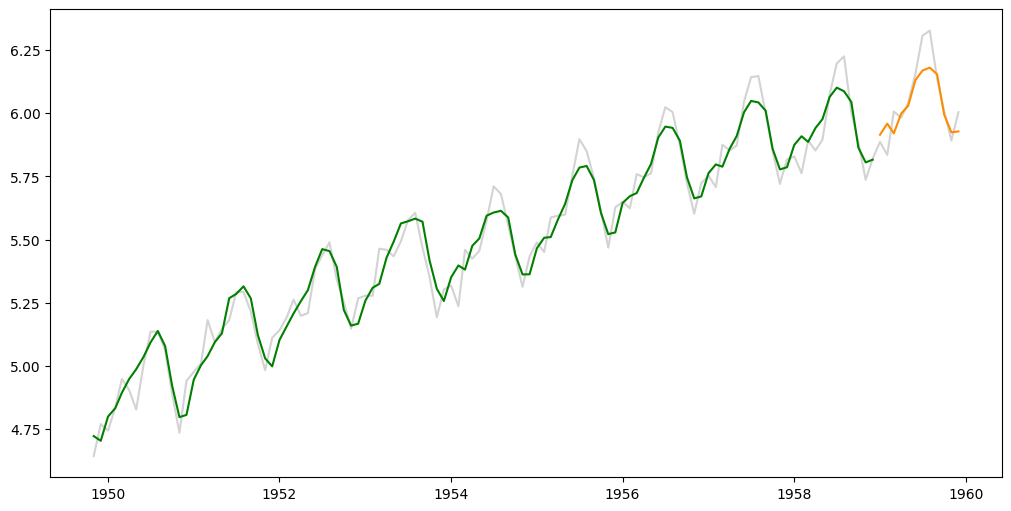

In [238]:
fig,ax = plt.subplots(figsize=(10,5), constrained_layout=True)
ax.plot(X_Train.index, y_Train, c='lightgray')
ax.plot(X_train.index, y_pred_train, c='g')
ax.plot(X_valid.index, y_pred_valid, c='darkorange')